# Digit Recognititon using CNN (Part 2 of Task 2)

Objective:

> Next, select only 0-9 training images from the above dataset, and use the pretrained
network to train on MNIST dataset. Use the standard MNIST train and test splits
(http://yann.lecun.com/exdb/mnist/). How does this pretrained network perform in
comparison to a randomly initialized network in terms of convergence time, final
accuracy and other possible training quality metrics? Do a thorough analysis. Please
save your model checkpoints.

## 1. Importing Libraries
---

In [24]:
import random
import copy
import time 
import pandas as pd 
from PIL import Image

import torch
import torchvision
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [25]:
from data import dataset
from plotting import plot_loss, plot_images
from model import Net
from train import train_model, compute_accuracy, cal_accuracy

## 2. Data Preprocessing
---

To change images into vector with normalisation and augmentation, following values are fetched to torchvision.transforms function. We perform: 
    
    - Random Rotations
    - Random Resizing and Cropping 
    - Change Image arrays to Tensor
    - Normalize

In [26]:
train_transforms = transforms.Compose([
                   transforms.RandomRotation(degrees=45),
                   transforms.RandomResizedCrop(64, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
                   transforms.ToTensor(),
                   transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])

               ])

The csv file here is generated from the script. This is for 'dataset' class that we import from data module. The standard splitting ratio, following Yann LeCun's MNIST data is 0.83 as 10000 images were for test and 60000 were for training. Our dataset is very small: only 400 images. Thus we take small batches and try to avoid overfitting and underfitting. 

In [27]:
ROOT = 'data/train'
NEW_LABELS = 'data/digit_labels.csv'
train_numbers = dataset(csv=NEW_LABELS, img_path=ROOT, transform = train_transforms)

VALID_RATIO = 0.83 #Stamdard split according to (http://yann.lecun.com/exdb/mnist/).
n_train_examples = int(len(train_numbers) * VALID_RATIO)
n_valid_examples = len(train_numbers) - n_train_examples
train_num_data, valid_num_data = data.random_split(train_numbers, [n_train_examples, n_valid_examples])

valid_num_data = copy.deepcopy(valid_num_data)
valid_num_data.dataset.transform = train_transforms

print(f'Number of training examples: {len(train_num_data)}')
print(f'Number of validation examples: {len(valid_num_data)}')

Number of training examples: 332
Number of validation examples: 68


In [28]:
train_num_iterator = data.DataLoader(train_num_data, batch_size = 4)
valid_num_iterator = data.DataLoader(valid_num_data, batch_size = 4)

In [29]:
df = pd.read_csv('data/digit_labels.csv')
df.head()

,filenames,labels_code,labels
0,img001-001.png,img001,0
1,img001-002.png,img001,0
2,img001-003.png,img001,0
3,img001-004.png,img001,0
4,img001-007.png,img001,0


Images of 0-9 digits that will fetched to our CNN. Our CNN is inspired by [AlexNet](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

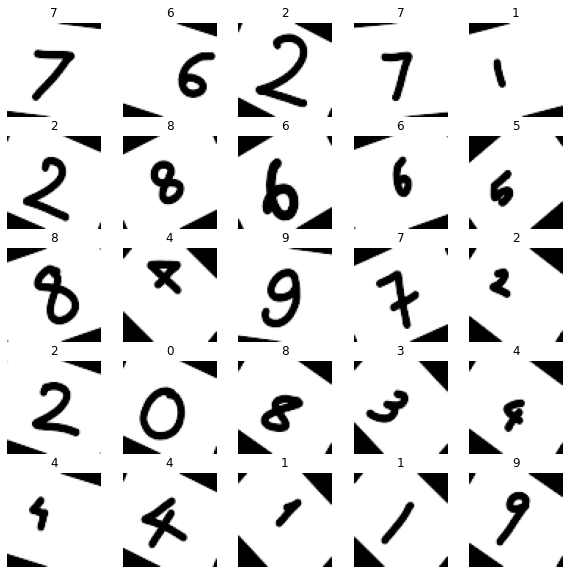

In [30]:
N_IMAGES = 25
images, labels = zip(*[(image, label) for image, label in [train_num_data[i] for i in range(N_IMAGES)]])
classes = list(df['labels'].unique())
plot_images(images, labels, classes)

## 3. Pretrained model loading and training 
---

The following model is loaded from training output of the first notebook: [Character Recognition](). In this case we have to train a pretrained model and model intialize from scratch. The pretrained model needs to be modified. The last layer of fully connected layer is changed to 10 output size as there are 10 classes. 

In [31]:
model_trained = Net(62)
model_trained.load_state_dict(torch.load('model.pt'))
model_trained.train()

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

In [32]:
model_trained.classifier[4] = torch.nn.Linear(4096,1024)
model_trained.classifier[6] = torch.nn.Linear(1024,10)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
model_trained.to(device)
criterion_num = torch.nn.CrossEntropyLoss()
optimizer_num = torch.optim.Adam(model_trained.parameters(), lr=1e-4)
device

device(type='cuda')

In [35]:
model_trained

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

In [36]:
train_loss_digits, valid_loss_digits, train_acc_digits, valid_acc_digits = train_model(model=model_trained, #pretrained model from section B.3.
                                             num_epochs=20,
                                             train_iterator=train_num_iterator,
                                             valid_iterator=valid_num_iterator, 
                                             optimizer=optimizer_num,
                                             criterion=criterion_num, 
                                            device=device, 
                                            model_save=False,
                                            model_name="model_1.pt")

Epoch: 1 	Training Loss: 0.576872 	Validation Loss: 0.575908
Epoch: 2 	Training Loss: 0.576177 	Validation Loss: 0.575982
Epoch: 3 	Training Loss: 0.575645 	Validation Loss: 0.575483
Epoch: 4 	Training Loss: 0.565165 	Validation Loss: 0.517500
Epoch: 5 	Training Loss: 0.526831 	Validation Loss: 0.505130
Epoch: 6 	Training Loss: 0.502754 	Validation Loss: 0.473800
Epoch: 7 	Training Loss: 0.486118 	Validation Loss: 0.454103
Epoch: 8 	Training Loss: 0.451968 	Validation Loss: 0.431537
Epoch: 9 	Training Loss: 0.422926 	Validation Loss: 0.397524
Epoch: 10 	Training Loss: 0.390504 	Validation Loss: 0.379227
Epoch: 11 	Training Loss: 0.381627 	Validation Loss: 0.436944
Epoch: 12 	Training Loss: 0.349418 	Validation Loss: 0.376175
Epoch: 13 	Training Loss: 0.328660 	Validation Loss: 0.316592
Epoch: 14 	Training Loss: 0.293178 	Validation Loss: 0.320677
Epoch: 15 	Training Loss: 0.298109 	Validation Loss: 0.315074
Epoch: 16 	Training Loss: 0.262642 	Validation Loss: 0.302995
Epoch: 17 	Traini

**Training and Validation Losses**

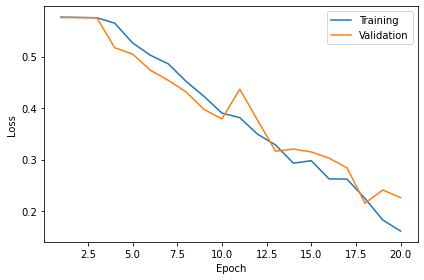

In [37]:
plot_loss(train_loss_digits, valid_loss_digits)

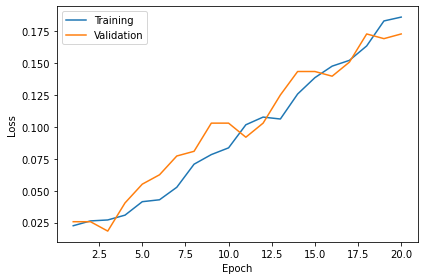

In [38]:
plot_loss(train_acc_digits, valid_acc_digits)

**Training and Validation Accuracy**

In [39]:
cal_accuracy(train_num_iterator, model_trained, device)

Got 240 / 332 with accuracy 72.29


In [40]:
cal_accuracy(valid_num_iterator, model_trained, device)

Got 49 / 68 with accuracy 72.06


## 4. Training model developed from scratch
---

In [41]:
model_digits = Net(10)
model_digits

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (

In [42]:
model_digits.to(device)
criterion_digits= torch.nn.CrossEntropyLoss()
optimizer_digits = torch.optim.Adam(model_digits.parameters(), lr=1e-4)
device

device(type='cuda')

In [43]:
tr_loss, val_loss, tr_acc, val_acc = train_model(model=model_digits, #model from scratch 
                                             num_epochs=20,
                                             train_iterator=train_num_iterator,
                                             valid_iterator=valid_num_iterator, 
                                             optimizer=optimizer_digits,
                                             criterion=criterion_digits, 
                                            device=device, 
                                            model_save = False,
                                            model_name="model_2.pt")

Epoch: 1 	Training Loss: 0.577566 	Validation Loss: 0.576110
Epoch: 2 	Training Loss: 0.576666 	Validation Loss: 0.576330
Epoch: 3 	Training Loss: 0.576311 	Validation Loss: 0.576180
Epoch: 4 	Training Loss: 0.576182 	Validation Loss: 0.576330
Epoch: 5 	Training Loss: 0.576434 	Validation Loss: 0.576081
Epoch: 6 	Training Loss: 0.574336 	Validation Loss: 0.575916
Epoch: 7 	Training Loss: 0.574618 	Validation Loss: 0.559115
Epoch: 8 	Training Loss: 0.553390 	Validation Loss: 0.535456
Epoch: 9 	Training Loss: 0.526602 	Validation Loss: 0.488738
Epoch: 10 	Training Loss: 0.511512 	Validation Loss: 0.465325
Epoch: 11 	Training Loss: 0.489997 	Validation Loss: 0.473949
Epoch: 12 	Training Loss: 0.473187 	Validation Loss: 0.438726
Epoch: 13 	Training Loss: 0.454978 	Validation Loss: 0.425837
Epoch: 14 	Training Loss: 0.425069 	Validation Loss: 0.410353
Epoch: 15 	Training Loss: 0.408973 	Validation Loss: 0.372619
Epoch: 16 	Training Loss: 0.371894 	Validation Loss: 0.354881
Epoch: 17 	Traini

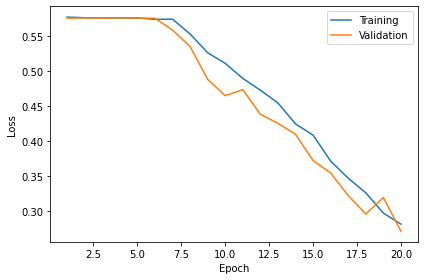

In [44]:
plot_loss(tr_loss, val_loss)

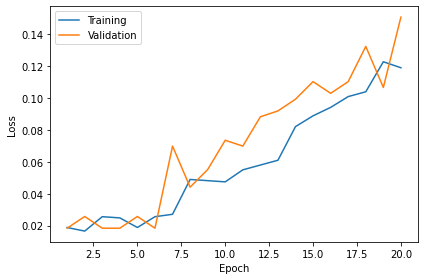

In [45]:
plot_loss(tr_acc, val_acc)

In [46]:
cal_accuracy(train_num_iterator, model_digits, device)


Got 201 / 332 with accuracy 60.54


In [47]:
cal_accuracy(valid_num_iterator, model_digits, device)

Got 39 / 68 with accuracy 57.35


## 5. Conclusion

In this notebook we notice that pretrained model works better than the model intitilized from scratch. In the pretrained case we observe accuracies around 72 percent for training and 70 percent for testing. This technique of taking a pretrained model and 'transferring' the knowledge is called **Transfer Learning**.  

# Thank you!

- Author : Pratik Kumar
- Date: April 2021
- Submitted to: MIDAS @IIITD
- References: 

    - [AlexNet Paper](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
    - [MNIST](http://yann.lecun.com/exdb/mnist/)
    - [PyTorch Tutorials](https://pytorch.org/tutorials/)